# Modelling toolbox: stochastic simulations

*19th September 2024* - **Credits:** Luca Ciandrini (luca.ciandrini@umontpellier.fr)

---

## aims
- Write a Monte Carlo simulation for the protein expression/degradation problem seen the previous lecture
- Develop an alternative simulation approach via the Gillespie algorithm (kinetic Monte Carlo)

We revise the equations that we ave analytically and numerically solved last week, and simulate different trajectories. At the end of the lecture you should be able to write a code to simulate a simple stochastic process (with two different methods), plot the trajectories and compare the results with the deterministic approach.

### 1-resources
- Check the resources associated to this lecture on the README file.

After you have done this tutorial, you can understand [this script](./Protein_partitioning.ipynb) for the stochastic protein partion problem (I'm going to introduce that during the lecture) - Theriot, J., Kondev, J., Garcia, H., Phillips, R. (2012). *Physical Biology of the Cell*. United Kingdom: CRC Press. Pages 43-48, available [here](https://www.google.fr/books/edition/Physical_Biology_of_the_Cell/t2SzDwAAQBAJ?hl=en&gbpv=1&printsec=frontcover)

# Tutorials

## Discrete stochastic

In [64]:
import matplotlib.pyplot as plt ## matplotlib is a module for plotting in python
import numpy as np

alpha = 1
mu = 0.1 
delta_t = 0.01

X = 0
t = 0

Xt = []
times = []
Xt.append(X)
times.append(t)

prob_prod = alpha*delta_t
prob_deg = X*mu*delta_t

t_max = 100

What are the 3 possible events in each time step? With which probability?

We are going to use the `random` library https://docs.python.org/3/library/random.html .

How would you try to simulate this situation? Think before looking down...



In [65]:
from random import random


while t < t_max :
    
    t += delta_t
    
    ran = random()
    
    prob_deg = X*mu*delta_t # Why do you have to compute that at each time step?
    
    if ran <= prob_prod:
        # production of 1 protein
        X = X + 1
    if ran > prob_prod and ran <= prob_prod + prob_deg :
        # degradation of 1 protein
        X = X - 1
        
    Xt.append(X)
    times.append(t)
    

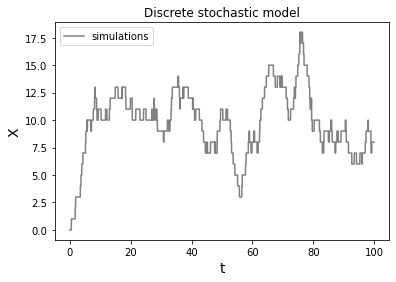

In [66]:
plt.plot(times,Xt, 'gray', label='simulations') 

#plt.ylim(0.,20.)
#plt.xlim(0.,t[-1])
plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend()
plt.show()

You can repeat the procedure and plot several *realisations*.

In [4]:
def sim_ge(a,m,delta,T):
    
    alpha = a
    mu = m 
    delta_t = delta

    X = 0
    t = 0.

    Xt = []
    times = []
    Xt.append(X)
    times.append(t)

    prob_prod = alpha*delta_t

    
    while t < T :
    
        t += delta_t
    
        ran = random()
    
        prob_deg = X*mu*delta_t # Why do you have to compute that at each time step?
    
        if ran <= prob_prod:
            # production of 1 protein
            X = X + 1
        if ran > prob_prod and ran <= prob_prod + prob_deg :
            # degradation of 1 protein
            X = X - 1
        
        Xt.append(X)
        times.append(t)
    
    return [times, Xt]

In [5]:
outcome = sim_ge(1,0.1,0.01,100)

In [9]:
print(outcome)

[[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.09999999999999999, 0.10999999999999999, 0.11999999999999998, 0.12999999999999998, 0.13999999999999999, 0.15, 0.16, 0.17, 0.18000000000000002, 0.19000000000000003, 0.20000000000000004, 0.21000000000000005, 0.22000000000000006, 0.23000000000000007, 0.24000000000000007, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014, 0.36000000000000015, 0.37000000000000016, 0.38000000000000017, 0.3900000000000002, 0.4000000000000002, 0.4100000000000002, 0.4200000000000002, 0.4300000000000002, 0.4400000000000002, 0.45000000000000023, 0.46000000000000024, 0.47000000000000025, 0.48000000000000026, 0.49000000000000027, 0.5000000000000002, 0.5100000000000002, 0.5200000000000002, 0.5300000000000002, 0.5400000000000003, 0.5500000000000003, 0.5600000000000003, 0

In [20]:
N_realisation = 10

t_realisation = []
X_realisation = []

delta_t = 0.01
for i in range(0,N_realisation):
    outcome = sim_ge(1,0.1,delta_t,100)
    
    t_realisation.append(outcome[0])
    X_realisation.append(outcome[1])
    #plt.plot(outcome[0],outcome[1], label=i) 

In [21]:
t_realisation

[[0.0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.060000000000000005,
  0.07,
  0.08,
  0.09,
  0.09999999999999999,
  0.10999999999999999,
  0.11999999999999998,
  0.12999999999999998,
  0.13999999999999999,
  0.15,
  0.16,
  0.17,
  0.18000000000000002,
  0.19000000000000003,
  0.20000000000000004,
  0.21000000000000005,
  0.22000000000000006,
  0.23000000000000007,
  0.24000000000000007,
  0.25000000000000006,
  0.26000000000000006,
  0.2700000000000001,
  0.2800000000000001,
  0.2900000000000001,
  0.3000000000000001,
  0.3100000000000001,
  0.3200000000000001,
  0.3300000000000001,
  0.34000000000000014,
  0.35000000000000014,
  0.36000000000000015,
  0.37000000000000016,
  0.38000000000000017,
  0.3900000000000002,
  0.4000000000000002,
  0.4100000000000002,
  0.4200000000000002,
  0.4300000000000002,
  0.4400000000000002,
  0.45000000000000023,
  0.46000000000000024,
  0.47000000000000025,
  0.48000000000000026,
  0.49000000000000027,
  0.5000000000000002,
  0.5100000000000002,

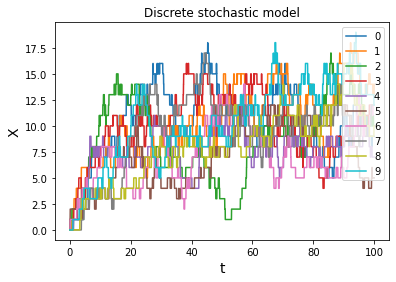

In [22]:
for i in range(0,N_realisation):
    plt.plot(t_realisation[i],X_realisation[i], label=i) 
    

plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend(loc=1)
plt.show()

What is the relation with the deterministic model?

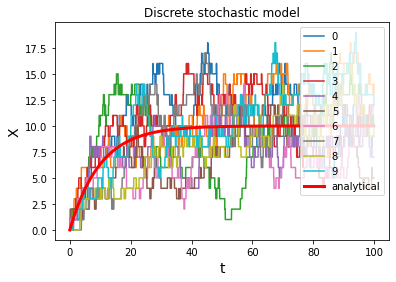

In [23]:
##### Plot the stochastic simulations 
for i in range(0,N_realisation):
    plt.plot(t_realisation[i],X_realisation[i], label=i) 
    


##### deterministic solution we found.
t = np.arange(0,100,.1) 

X = (alpha/mu)*(1.-np.exp(-mu*t))  
plt.plot(t,X, lw=3,color='red', label='analytical')

plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend(loc=1)
plt.show()


In [24]:
import numpy as np

# Assuming you have collected data in t_realisation and X_realisation

# Convert X_realisation to a NumPy array
X_combined = np.array(X_realisation)

# Initialize an array to store the time-averaged values
X_average = []

# Iterate through each time point in t_realisation
for time_index in range(len(t_realisation[0])):
    # Extract the values of X at the current time for all realizations
    X_at_time = X_combined[:, time_index]
    # At each time point, we extract the values of X from all realizations at that specific time point. 
    # We use *NumPy slicing* to achieve this. X_combined[:, time_index] selects all rows (realizations) 
    # and the time_index-th column (the current time point).
    # The colon : before the comma represents that we want to include all rows (realizations). It's a way of saying "select all rows."
    
    # Calculate the average value at the current time
    average_value = np.mean(X_at_time)
    
    # Append the average to the X_average array
    X_average.append(average_value)

# Convert X_average to a NumPy array
X_average = np.array(X_average)

# Now, X_average contains the time-averaged values of X

### NumPy Array Slicing Cheatsheet

#### Basics:

- `arr[start:stop]`: Return elements from `start` (inclusive) to `stop` (exclusive).
- `arr[start:]`: Return elements from `start` to the end of the array.
- `arr[:stop]`: Return elements from the beginning to `stop` (exclusive).
- `arr[:]`: Return a copy of the entire array.

#### Using Step:

- `arr[start:stop:step]`: Return elements from `start` to `stop` with a step of `step`.

#### Negative Indices:

- Negative indices count from the end of the array.
- `-1` refers to the last element, `-2` to the second-to-last, and so on.

#### Multidimensional Arrays:

- For 2D arrays, use a comma to separate slicing for rows and columns.
- `arr[row_start:row_stop, col_start:col_stop]`: Slice rows and columns.

#### Slicing by Rows or Columns:

- `arr[:, col]`: Select all rows from a specific column.
- `arr[row, :]`: Select all columns from a specific row.

#### Slicing by Condition:

- `arr[arr_condition]`: Select elements that satisfy the condition.

#### Example Usage:


In [47]:
import numpy as np

arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Slicing basics
slice1 = arr[2:6]  # [2, 3, 4, 5]
slice2 = arr[:5]   # [0, 1, 2, 3, 4]
slice3 = arr[5:]   # [5, 6, 7, 8, 9]

# Step
slice4 = arr[1:9:2]  # [1, 3, 5, 7]

# Negative indices
slice5 = arr[-3:]    # [7, 8, 9]

# 2D array slicing
arr2D = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
slice6 = arr2D[:2, 1:]  # [[2, 3], [5, 6]]

# Slicing by condition
condition = arr > 4
slice7 = arr[condition]  # [5, 6, 7, 8, 9]

---

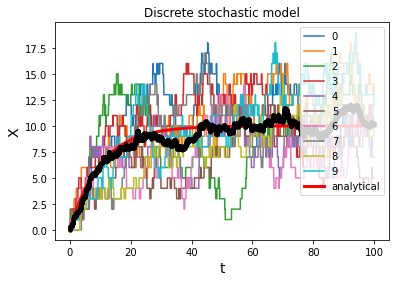

In [37]:
##### Plot the stochastic simulations 
for i in range(0,N_realisation):
    plt.plot(t_realisation[i],X_realisation[i], label=i) 


##### deterministic solution we found.
t = np.arange(0,100,.1) 

X = (alpha/mu)*(1.-np.exp(-mu*t))  
plt.plot(t,X, lw=3,color='red', label='analytical')

plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend(loc=1)



##### Plot the average X
plt.plot(t_realisation[0], X_average,'o', mew=0.2, ms=4, color='black', alpha=0.5)

plt.show()

- To be done: Compare mean value of trajectories with the analatycal solution.
- What about the steady state?

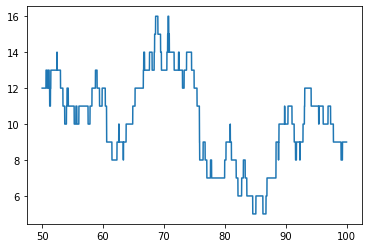

In [38]:
t_ss = int(50/delta_t)
plt.plot(t_realisation[0][t_ss:],X_realisation[0][t_ss:])

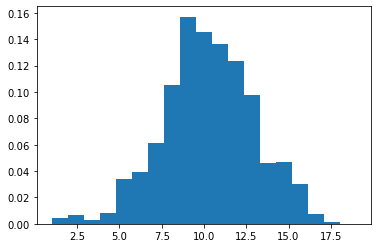

In [39]:
X_tot = []
for i in range(0,N_realisation): X_tot.extend(X_realisation[i][t_ss:])
plt.hist(X_tot, density=True, bins = max(X_tot)- min(X_tot)+1);

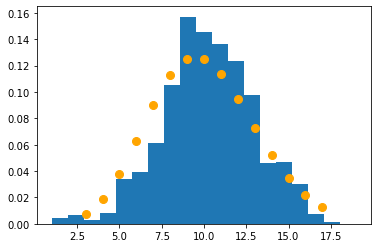

In [40]:
from scipy.stats import poisson

mean = alpha/mu

x = np.arange(poisson.ppf(0.01, mean),
              poisson.ppf(0.99, mean))
plt.plot(x, poisson.pmf(x, mean), 'o', ms=8, color='orange', label='poisson pmf')
plt.hist(X_tot, density=True, bins = max(X_tot)- min(X_tot)+1);

- What are the advantages of this method?
- What are the drawbacks?
---

## Kinetic Monte Carlo (Gillespie Algorithm)

The Gillespie algorithm is used to simulate trajectories of a system of stochastic equations for which the reaction rates are known. It is a discrete event simulation algorithm, but the $\Delta t$ varies.

There are two random numbers involved: one for the choice of the reaction (`r`), the other for the time interval (`dt`). The first is extracted from a uniform distribution, the second from an exponential (from [inverse sampling](https://en.wikipedia.org/wiki/Exponential_distribution#Random_variate_generation) as done here or you could just use a python module).

In [48]:
# Step 1: Initialise
t_gil = 0
x_gil = 0

T_gil = []
X_gil = []
T_gil.append(t_gil)
X_gil.append(x_gil)

alpha = 1.
mu = 0.1 

In [49]:
# Step 2: define the propensities of all possible events
a = []
a.append(alpha) # production - reaction 0
a.append(mu*x_gil) # degradation - reaction 1
A = sum(a)
print(a, A)

[1.0, 0.0] 1.0


In [50]:
# Step 3: find the next time 
r1 = random()
dt = (1./A)*np.log(1./r1)
print(r1, dt)



0.010059477644660864 4.599240039648615


In [51]:
# Step 4: pick the reaction
r2 = A*random()
if r2 < a[0]:
    x_gil += 1 # create a protein
else :
    x_gil -= 1 # destroy a protein

print(x_gil)


1


In [52]:
# Step 5: record simulation time and state
t_gil += dt
T_gil.append(t_gil)
X_gil.append(x_gil)

In [83]:
# (Reinitialise)
t_gil = 0
x_gil = 0

T_gil = []
X_gil = []
T_gil.append(t_gil)
X_gil.append(x_gil)

# Step 6: repeat until done

t_max = 100
while (t_gil<t_max):
    
    # Step 2: define the propensities of all possible events
    a[1] = mu*x_gil # degradation - reaction 1 (production does not change, no need to update)
    A = sum(a)
   
    
    # Step 3: find the next time 
    r1 = random()
    dt = (1./A)*np.log(1./r1)
    
    # Step 4: pick the reaction
    r2 = A*random()
    if r2 < a[0]:
        x_gil += 1 # create a protein
    else :
        x_gil -= 1 # destroy a protein
        
    # Step 5: record simulation time and state
    t_gil += dt
    T_gil.append(t_gil)
    X_gil.append(x_gil)
    

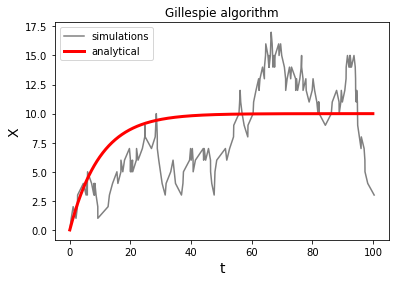

In [84]:
plt.plot(T_gil,X_gil, 'gray', label='simulations') 

#plt.ylim(0.,20.)
#plt.xlim(0.,t[-1])
plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Gillespie algorithm')


##### deterministic solution we found.
t = np.arange(0,100,.1) 

X = (alpha/mu)*(1.-np.exp(-mu*t))  
plt.plot(t,X, lw=3,color='red', label='analytical')


plt.legend()
plt.show()

- Do several realisations and plot them.
- compute the average of them. Problem?